In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os
import cv2

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms
from torch.optim import AdamW
import timm
from PIL import Image

device = torch.device('mps')


#### Data Visualization & Preprocessing

In [3]:
path_to_data = 'XXX'

train_df = pd.read_csv('train.csv')
train_df = train_df[train_df['is_tma'] == False]
train_df = train_df.reset_index(drop=True)
train_df.head()

,image_id,label,image_width,image_height,is_tma
0,4,HGSC,23785,20008,False
1,66,LGSC,48871,48195,False
2,281,LGSC,42309,15545,False
3,286,EC,37204,30020,False
4,431,HGSC,39991,40943,False


In [5]:
def get_image_size(row):
    img = Image.open(f"train_thumbnails/{row['image_id']}_thumbnail.png")
    return pd.Series([img.size[1], img.size[0]])

train_df[['thumbnail_height', 'thumbnail_width']] = train_df.apply(get_image_size, axis=1)
train_df.head()

,image_id,label,image_width,image_height,is_tma,thumbnail_height,thumbnail_width
0,4,HGSC,23785,20008,False,2523,3000
1,66,LGSC,48871,48195,False,2958,3000
2,281,LGSC,42309,15545,False,1102,3000
3,286,EC,37204,30020,False,2420,3000
4,431,HGSC,39991,40943,False,3071,3000


In [6]:
train_df['thumbnail_height'].describe()

count     513.000000
mean     2011.863548
std       805.073983
min       530.000000
25%      1412.000000
50%      1943.000000
75%      2479.000000
max      7842.000000
Name: thumbnail_height, dtype: float64

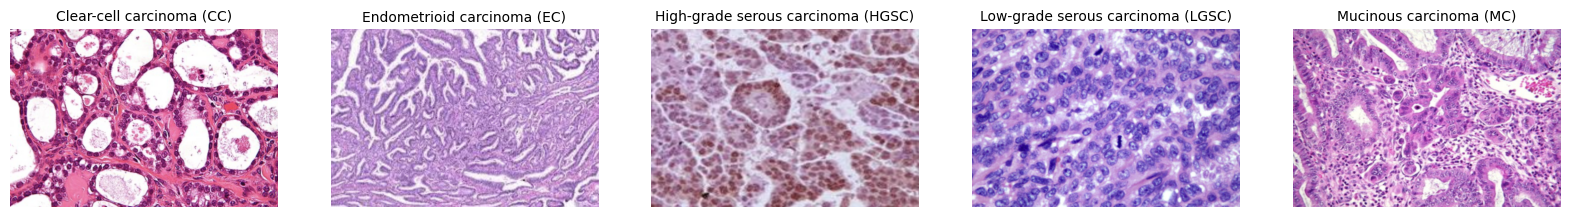

In [7]:
image_paths = ['CC.png', 'EC.png', 'HGSC.png', 'LGSC.png', 'MC.png']
labels = ['Clear-cell carcinoma (CC)', 'Endometrioid carcinoma (EC)', 'High-grade serous carcinoma (HGSC)', 'Low-grade serous carcinoma (LGSC)', 'Mucinous carcinoma (MC)']

fig, ax = plt.subplots(1, 5, figsize=(20, 10))
for i, path in enumerate(image_paths):
    img = Image.open(path)
    img = img.resize((720, 480))
    ax[i].imshow(img)
    ax[i].set_title(labels[i], fontsize=10)
    ax[i].axis('off')

(-0.5, 2999.5, 2522.5, -0.5)

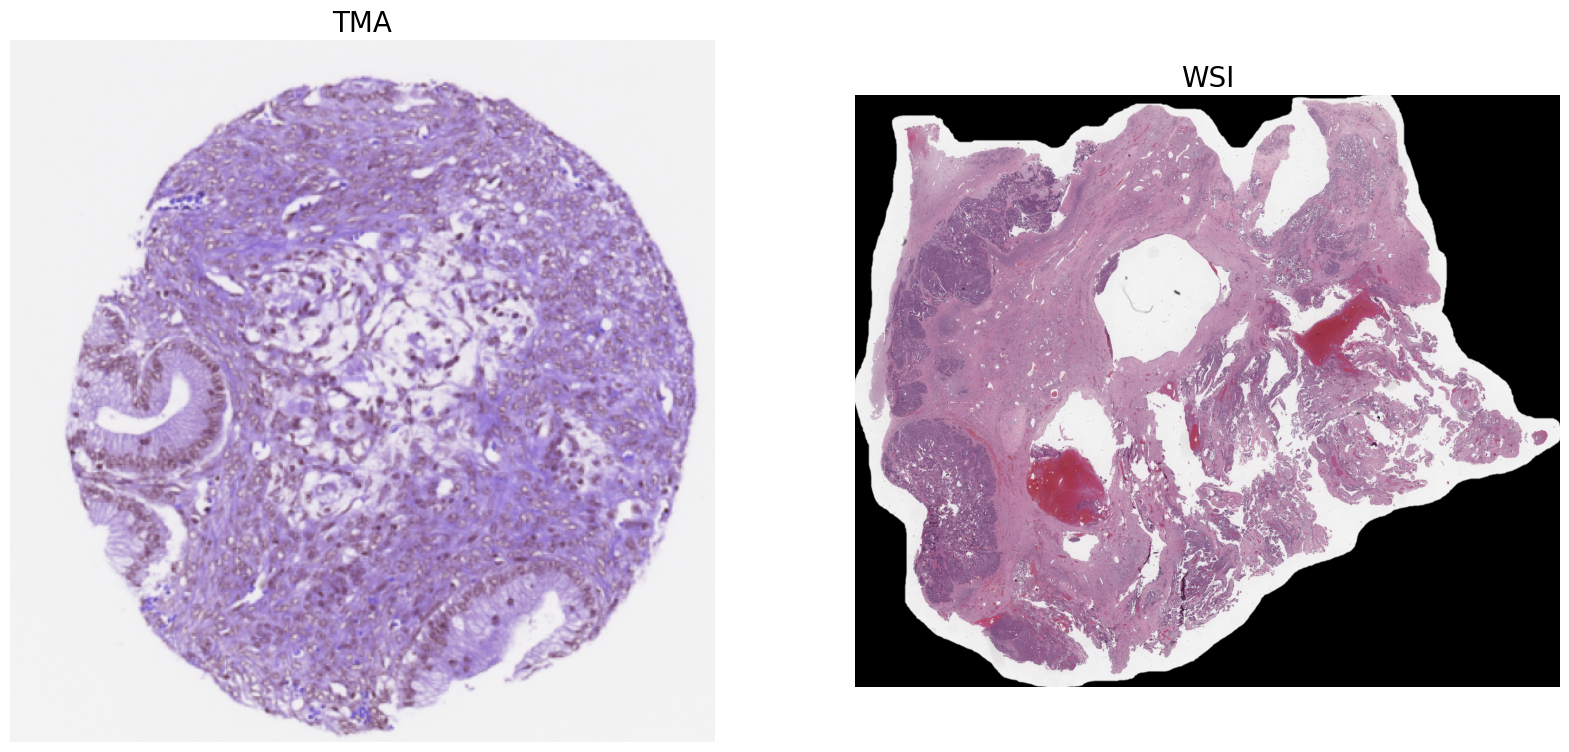

In [8]:

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
img = Image.open('TMA_example.png')
ax[0].imshow(img)
ax[0].set_title('TMA', fontsize=20)
ax[0].axis('off')

img = Image.open('train_thumbnails/4_thumbnail.png')
ax[1].imshow(img)
ax[1].set_title('WSI', fontsize=20)
ax[1].axis('off')



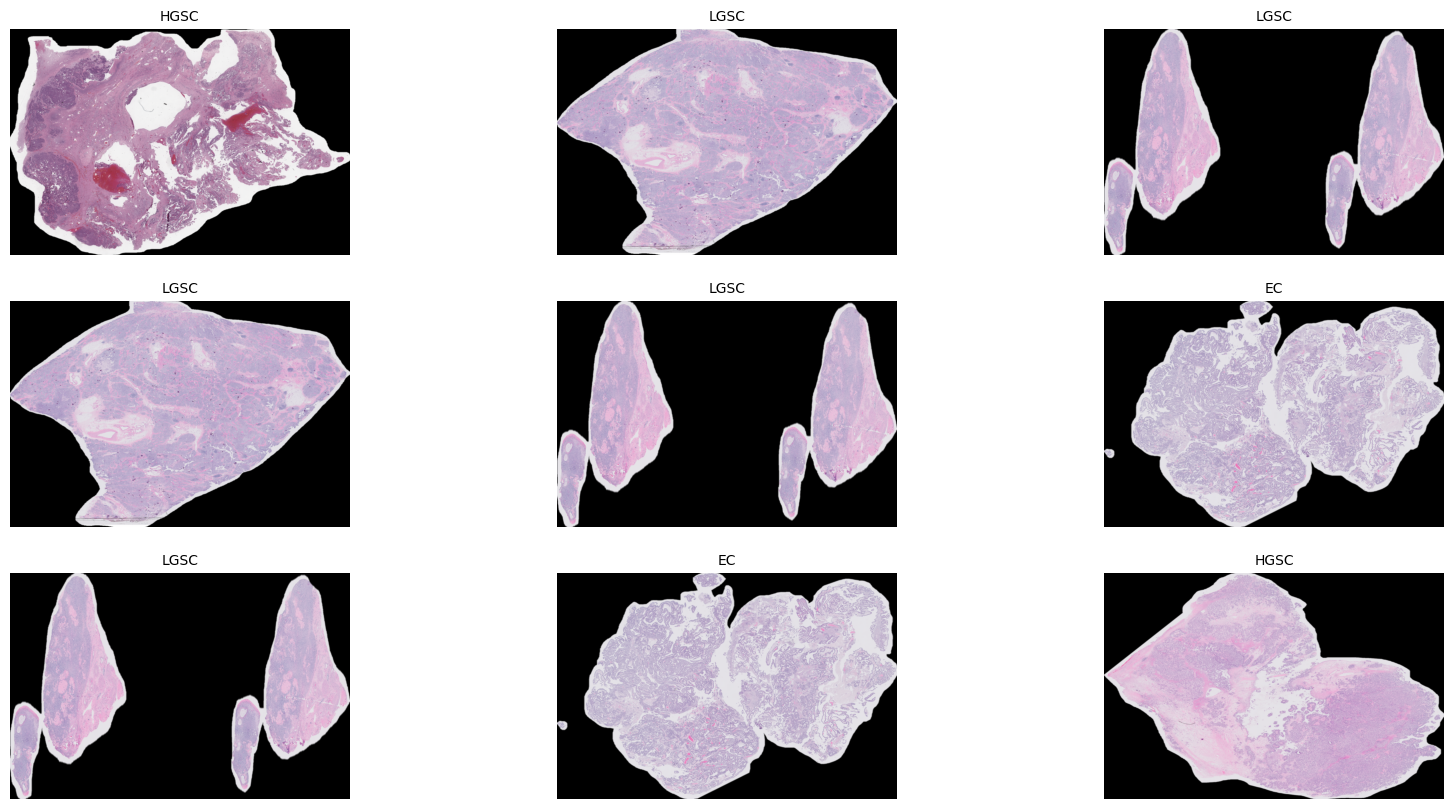

In [9]:

fig, ax = plt.subplots(3, 3, figsize=(20, 10))
for i in range(3):
    for j in range(3):
        img = Image.open(f"train_thumbnails/{train_df['image_id'][i+j]}_thumbnail.png")
        img = img.resize((720, 480))
        ax[i, j].imshow(img)
        ax[i, j].set_title(train_df['label'][i+j], fontsize=10)
        ax[i, j].axis('off')

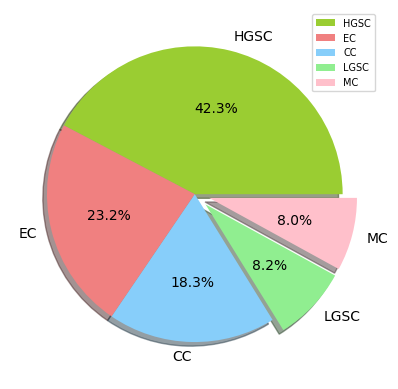

In [11]:
colors_list = ['yellowgreen', 'lightcoral', 'lightskyblue', 'lightgreen', 'pink']
explode_list = [0, 0, 0, 0.1, 0.1] 

train_df['label'].value_counts().plot(kind='pie',autopct="%.1f%%", shadow= True,
                                     colors= colors_list, explode= explode_list)
#plt.title("Ovarian Cancer Types Distributions")
plt.legend(loc= 'best', fontsize = 7)
plt.axis('off')
plt.show()

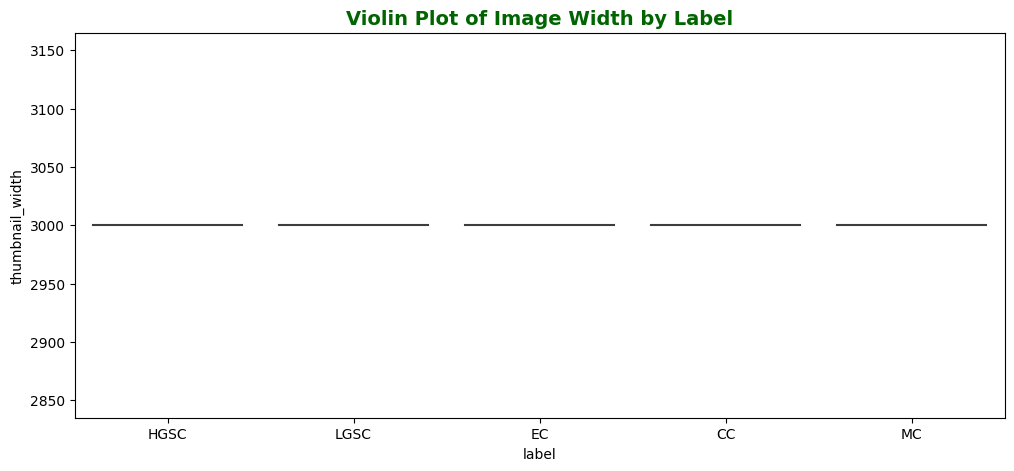

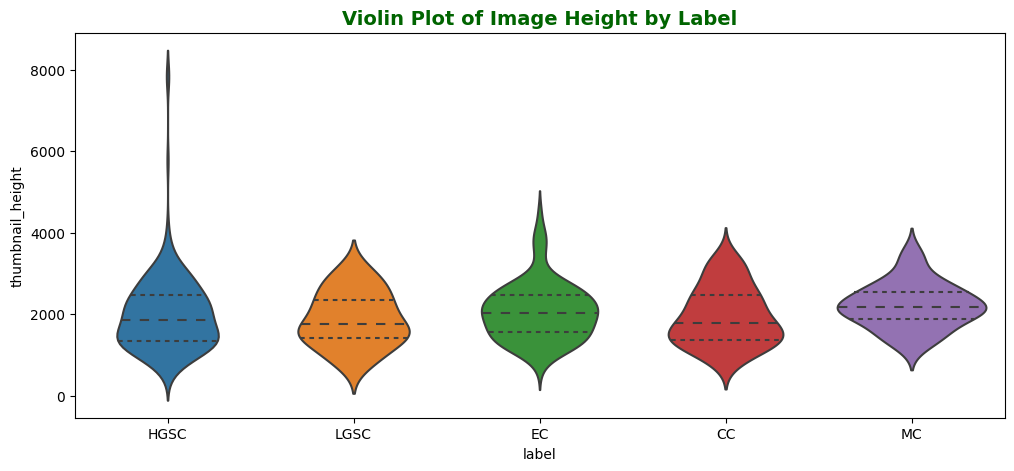

In [12]:
plt.figure(figsize=(12, 5))
sns.violinplot(x='label', y='thumbnail_width', data=train_df, inner='quartile')
plt.title('Violin Plot of Image Width by Label', fontsize = 14, fontweight = 'bold', color = 'darkgreen')
plt.savefig('Violin Plot of Image Width by Label.png')
plt.show()

plt.figure(figsize=(12, 5))
sns.violinplot(x='label', y='thumbnail_height', data=train_df, inner='quartile')
plt.title('Violin Plot of Image Height by Label', fontsize = 14, fontweight = 'bold', color = 'darkgreen')
plt.savefig('Violin Plot of Image Height by Label.png')
plt.show()

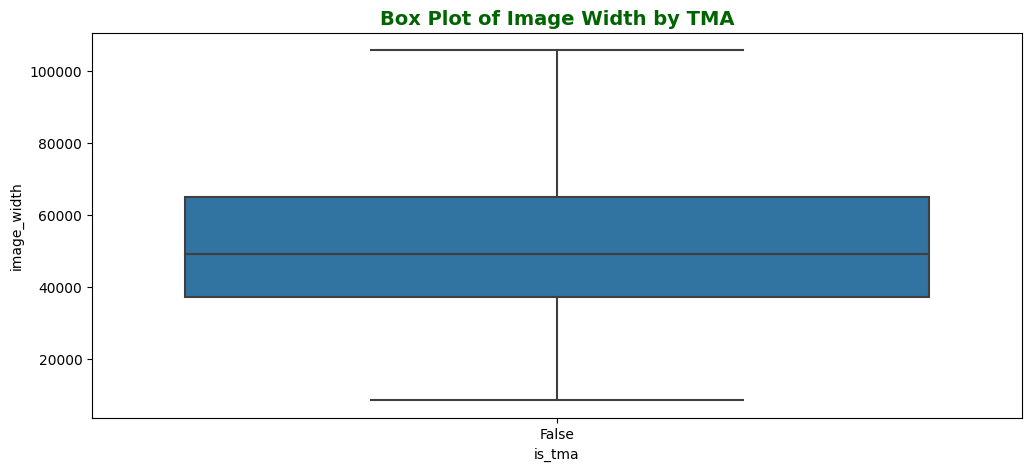

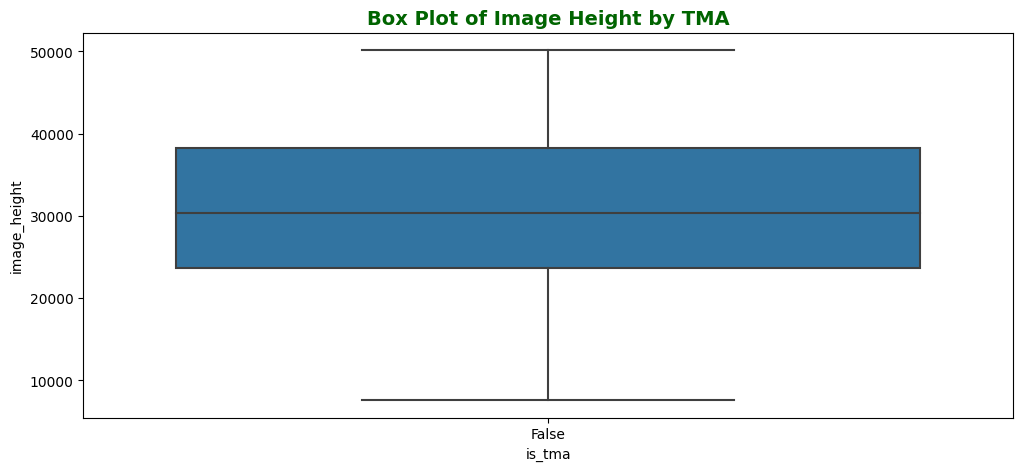

In [14]:
plt.figure(figsize=(12, 5))
sns.boxplot(x='is_tma', y='image_width', data=train_df)
plt.title('Box Plot of Image Width by TMA', fontsize = 14, fontweight = 'bold', color = 'darkgreen')
plt.savefig('Box Plot of Image Width by TMA.png')
plt.show()

plt.figure(figsize=(12, 5))
sns.boxplot(x='is_tma', y='image_height', data=train_df)
plt.title('Box Plot of Image Height by TMA', fontsize = 14, fontweight = 'bold', color = 'darkgreen')
plt.savefig('Box Plot of Image Height by TMA.png')
plt.show()

In [10]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(train_df, train_df["label"]):
    train_set = train_df.loc[train_index]
    val_set = train_df.loc[test_index]

train_set = train_set.reset_index(drop=True)
val_set = val_set.reset_index(drop=True)

In [13]:
train_df['thumbnail_height'].describe()

count     513.000000
mean     2011.863548
std       805.073983
min       530.000000
25%      1412.000000
50%      1943.000000
75%      2479.000000
max      7842.000000
Name: thumbnail_height, dtype: float64

#### Patch the original image

In [15]:
def get_tiles(img, tile_size=256, n_tiles=30, mode=0):
    h, w, c = img.shape
    pad_h = (tile_size - h % tile_size) % tile_size + ((tile_size * mode) // 2)
    pad_w = (tile_size - w % tile_size) % tile_size + ((tile_size * mode) // 2)

    img = np.pad(
        img,
        [[pad_h // 2, pad_h - pad_h // 2], [pad_w // 2, pad_w - pad_w // 2], [0, 0]],
        constant_values=0,
    )
    img = img.reshape(
        img.shape[0] // tile_size, tile_size, img.shape[1] // tile_size, tile_size, 3
    )
    img = img.transpose(0, 2, 1, 3, 4).reshape(-1, tile_size, tile_size, 3)

    idxs = np.argsort(img.reshape(img.shape[0], -1).sum(-1))
    if len(img) < n_tiles:
        img = np.pad(
            img, [[0, n_tiles - len(img)], [0,0], [0,0], [0,0]], constant_values=255
        )
    # idxs = np.argsort(-img.reshape(img.shape[0], -1).sum(-1))[:n_tiles]
    # print(type(idxs))
    if idxs.shape[0]>n_tiles:
        idxs = idxs[-n_tiles:]
    img = img[idxs]
    
    return img, (pad_h, pad_w, h, w)

def concat_tiles(tiles, n_tiles, image_size):
    idxes = list(range(n_tiles))
    
    n_row_tiles = int(np.sqrt(n_tiles))
    img = np.zeros(
        (image_size*n_row_tiles, image_size*n_row_tiles, 3), dtype="uint8"
    )
    
    for h in range(n_row_tiles):
        for w in range(n_row_tiles):
            i = h * n_row_tiles + w
            if len(tiles) > idxes[i]:
                this_img = tiles[idxes[i]]
            else:
                this_img = np.ones((image_size, image_size, 3), dtype="uint8") * 255
                
            h1 = h * image_size
            w1 = w * image_size
            img[h1 : h1 + image_size, w1 : w1 + image_size] = this_img
    return img

def sort_tiles_by_intensity(tiles):
    intensities = np.mean(tiles, axis=(1, 2, 3))  # Calculate mean intensity for each tile
    
    sorted_indices = np.argsort(-intensities)
    
    sorted_tiles = tiles[sorted_indices]
    sorted_intensities = intensities[sorted_indices]
    
    return sorted_tiles, sorted_intensities, sorted_indices

def draw_grid(image, tile_size, pad_h, pad_w, h, w):
    grid_image = image.copy()
    for y in range(0, h + pad_h, tile_size):
        grid_image = cv2.line(grid_image, (0, y), (w + pad_w, y), (255, 255, 255), 10)
    for x in range(0, w + pad_w, tile_size):
        grid_image = cv2.line(grid_image, (x, 0), (x, h + pad_h), (255, 255, 255), 10)
    return grid_image

In [ ]:
img = Image.open('train_thumbnails/4_thumbnail.png')
img = np.array(img)
tiles, _ = get_tiles(img, tile_size=256, n_tiles=30, mode=0)
print(tiles[0].shape)


In [ ]:
img = cv2.imread('train_thumbnails/4_thumbnail.png')

tiles, padding_info = get_tiles(img,tile_size=256)

pad_h, pad_w, h, w = padding_info
grid_image = draw_grid(img, 256, pad_h, pad_w, h, w)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(grid_image, cv2.COLOR_BGR2RGB))
plt.title('Image with Grid')
plt.axis('off')

plt.show()

In [ ]:
sorted_tiles, _, _ = sort_tiles_by_intensity(tiles)
print(len(sorted_tiles))
concatenated_image = concat_tiles(sorted_tiles, len(sorted_tiles), 256)  # Assuming each tile is 256x256
print(concatenated_image.shape)
plt.figure(figsize=(10, 10))
plt.imshow(concatenated_image)
plt.title('Concatenated Tiles')
plt.axis('off')
plt.show()


#### ViT Model

In [73]:
class ViT(nn.Module):
    def __init__(self, num_classes, image_size=224, backbone='vit_base_patch16_224', finetune_layer=True):
        super(ViT, self).__init__()
        self.model = timm.create_model(backbone, pretrained=True)
        
        if finetune_layer:
            for param in self.model.parameters():
                param.requires_grad = False
            self.model.head = nn.Identity()
            self.finetune_layer = nn.Sequential(
                nn.Linear(self.model(torch.randn(1, 3, image_size, image_size)).shape[-1], 512),
                nn.ReLU(),
                nn.Linear(512, num_classes)
            )
        else:
            self.model.head = nn.Linear(self.model.head.in_features, num_classes)
            self.finetune_layer = None

    def forward(self, x):
        return self.model(x)

#### Prepare the data

In [134]:
id2label = {0: 'CC', 1: 'EC', 2: 'HGSC', 3: 'LGSC', 4: 'MC'}
label2id = {v: k for k, v in id2label.items()}

In [135]:
class UCBDataset(Dataset):
    def __init__(self, metadata_df, image_folder, transform=None):
        self.metadata_df = metadata_df
        self.image_folder = image_folder
        self.transform = transform  # Use the provided transform
    def __len__(self):
        return len(self.metadata_df)
    def __getitem__(self, idx):
        image_ids = self.metadata_df.image_id[idx]  
        image_name = os.path.join(self.image_folder, "{}_thumbnail.png".format(image_ids))
        image = Image.open(image_name)
        img, _ = get_tiles(
            np.array(image),
            mode=0, n_tiles= 64
        )
        
        sorted_img, _, _ = sort_tiles_by_intensity(img)
        img = concat_tiles(
            sorted_img, 64, 256
        )

        # img = to_tensor(img)
        img = Image.fromarray(img)
        
        if self.transform:
            img = self.transform(img)
            
        label = label2id[self.metadata_df.label[idx]]

        return img,label

In [182]:
data_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomRotation(degrees=15),  # Rotation
    transforms.RandomVerticalFlip(),  # Flip Up-Down
    transforms.RandomHorizontalFlip(),  # Flip Left-Right
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0, hue=0.05),  # Random brightness, contrast, and hue
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

unique_classes = np.unique(train_set['label'])
class_weights = compute_class_weight(class_weight='balanced', classes=unique_classes, y=train_set['label'])
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

sample_weights = [class_weights[i] for i,_ in enumerate(unique_classes)]
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)


train_dataset = UCBDataset(metadata_df=train_set, image_folder='train_thumbnails', transform=data_transforms)
val_dataset = UCBDataset(metadata_df=val_set, image_folder='train_thumbnails', transform=data_transforms)

batch_size = 16
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

#### Training & Results

In [191]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    loader = tqdm(train_loader, desc="Training", leave=False)

    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        try : 
            if model.finetune_layer is not None:
                outputs = model.finetune_layer(outputs)
        except:
            pass
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        loader.set_postfix({'Loss': total_loss / len(loader)})
        
    return total_loss / len(train_loader)

def test(model, test_loader, criterion, device):
    model.eval()
    all_preds = []
    all_labels = []
    total_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            try : 
                if model.finetune_layer is not None:
                    outputs = model.finetune_layer(outputs)
            except : 
                pass
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    conf = confusion_matrix(all_labels, all_preds)

    return total_loss / len(test_loader), accuracy, f1, conf

In [192]:
class EarlyStopping:
    def __init__(self, patience=4, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_accuracy, model):
        score = val_accuracy

        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0


In [193]:
criterion = nn.CrossEntropyLoss(weight=class_weights)
model = ViT(num_classes=5).to(device)
optimizer = AdamW(model.parameters(), lr=0.0001, weight_decay=0.001)
early_stopping = EarlyStopping(patience=4, verbose=True)
epochs = 30
device = torch.device('mps')

# Assuming you have train_loader and test_loader defined
for epoch in range(epochs):
    train_loss = train(model, train_dataloader, criterion, optimizer, device)
    test_loss, accuracy, f1, conf = test(model, val_dataloader, criterion, device)

    early_stopping(accuracy, model)
    if early_stopping.early_stop:
        print("Early stopping")
        break
    print(f'Epoch {epoch + 1}/{epochs}, '
          f'Train Loss: {train_loss:.4f}, '
          f'Test Loss: {test_loss:.4f}, '
          f'Accuracy: {accuracy:.4f}, '
          f'F1 Score: {f1:.4f}')

Epoch 1/30, Train Loss: 1.6564, Test Loss: 1.6822, Accuracy: 0.2330, F1 Score: 0.1685


Epoch 2/30, Train Loss: 1.4038, Test Loss: 1.6678, Accuracy: 0.2621, F1 Score: 0.1778


EarlyStopping counter: 1 out of 4
Epoch 3/30, Train Loss: 1.3211, Test Loss: 1.7335, Accuracy: 0.1845, F1 Score: 0.1161


EarlyStopping counter: 2 out of 4
Epoch 4/30, Train Loss: 1.2423, Test Loss: 1.7980, Accuracy: 0.1845, F1 Score: 0.1097


EarlyStopping counter: 3 out of 4
Epoch 5/30, Train Loss: 1.2117, Test Loss: 1.7419, Accuracy: 0.2136, F1 Score: 0.1258


EarlyStopping counter: 4 out of 4
Early stopping


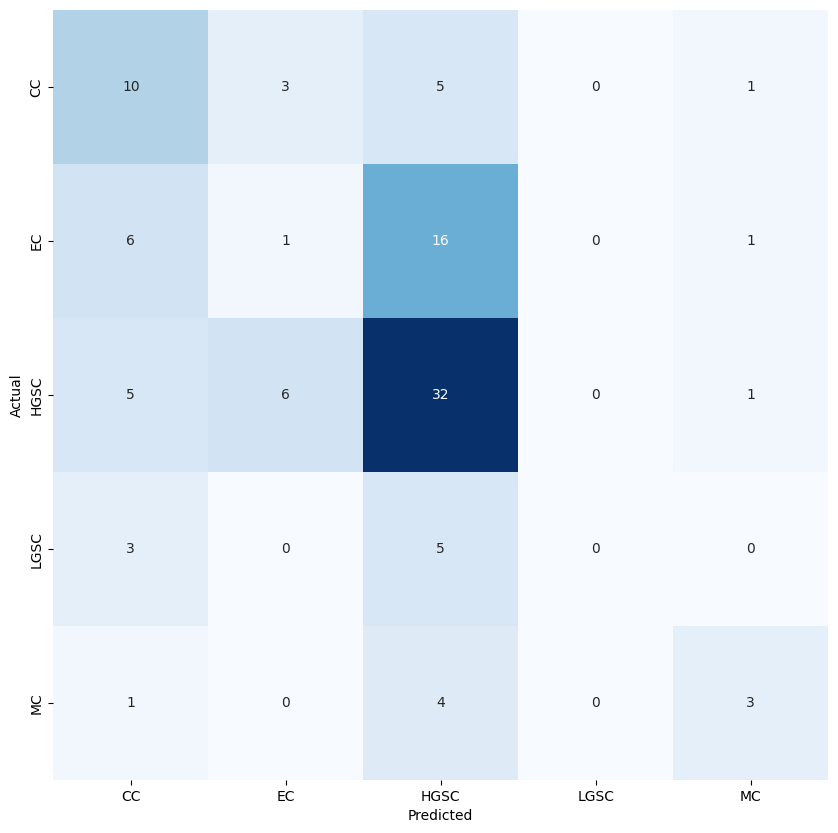

In [249]:

plt.figure(figsize=(10, 10))
sns.heatmap(conf, annot=True, fmt="d", cmap='Blues', cbar=False, 
            xticklabels=id2label.values(), yticklabels=id2label.values())
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()
